# Mackenzie runoff climatology

In [1]:
## import required packages
import numpy as np
import pandas as pd
import sys
import xarray as xr
import matplotlib.pyplot as plt
import s3fs
import cmocean
import gsw
import matplotlib.dates as mdates
import time
import cartopy.crs as ccrs
import warnings
warnings.filterwarnings("ignore", module='distributed')

In [2]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:45187")
client

<Client: 'tcp://127.0.0.1:45187' processes=8 threads=32, memory=123.95 GiB>

In [3]:
# initialize s3 filesystem
s3_options = dict(anon=False)

In [4]:
# open geometry file for HH field
HH_grid = xr.open_dataset("~/efs-mount-point/mzahn/sassie/HH/GRID/GRID_GEOMETRY_SASSIE_HH_V1R1_NATIVE_LLC1080.nc")

In [5]:
# function to open zarr store with a provided s3 bucket path
def open_zarr_store(s3_path, s3_options):
    # initalize s3 file system
    s3 = s3fs.S3FileSystem(**s3_options)

    # define location of zarr store and open
    store = s3fs.S3Map(root=s3_path, s3=s3, check=False)
    zarr_store = xr.open_zarr(store)
    
    return zarr_store

### Open daily mean ZARR datasets

In [9]:
# open runoff zarr store - [m s-1]
runoff_da = open_zarr_store('s3://ecco-processed-data/SASSIE/N1/HH/ZARR/EXFroff_AVG_DAILY.ZARR/', s3_options)

In [10]:
# carve out beaufort region
runoff_da_beaufort = runoff_da.EXFroff.isel(i=slice(450,750),j=slice(110,390))

HH_grid_land = HH_grid.maskC.isel(k=0).where(HH_grid.maskC.isel(k=0)==0)
HH_land_beaufort = HH_grid_land.isel(i=slice(450,750),j=slice(110,390))

# Plot climatology

In [11]:
runoff_monthly = runoff_da_beaufort.groupby('time.month').mean(dim='time')

In [12]:
runoff_month_clim = runoff_monthly.sum(dim=['i','j'])

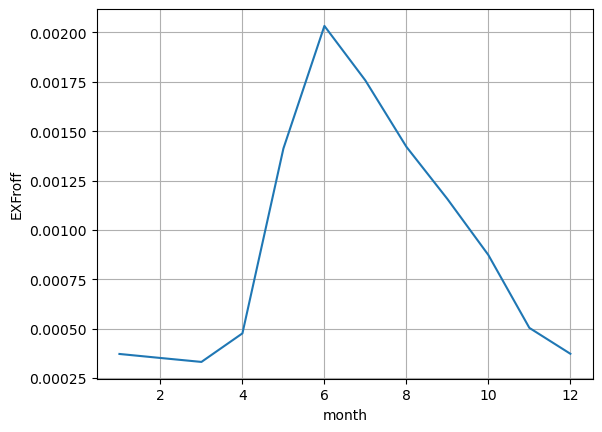

In [13]:
runoff_month_clim.plot()
plt.grid();

## Convert to cubic meters per second

In [14]:
beaufort_area = HH_grid.rAc.isel(i=slice(450,750),j=slice(110,390))

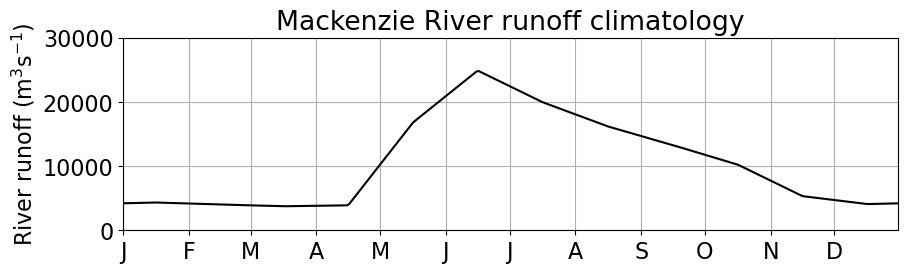

In [15]:
plt.rcParams['font.size'] = 16

(runoff_da_beaufort.sel(time='2020')*beaufort_area).sum(dim=['i','j']).plot(color='k',figsize=[10,2.5])
plt.xlim([np.datetime64('2020-01-01'),np.datetime64('2020-12-31')])
plt.xlabel("")
plt.ylim(0,3e4)

dates = pd.date_range('2020-01-01', '2020-12-01', freq='MS')
plt.xticks(ticks=dates, labels=['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])

plt.ylabel("River runoff (m$^3$s$^{-1}$)")
plt.title("Mackenzie River runoff climatology")
plt.grid();